In [ ]:
!wget --no-check-certificate \
     http://nlp.stanford.edu/data/glove.6B.zip \
     -O /tmp/glove.6B.zip

--2022-08-02 18:05:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-02 18:05:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-02 18:05:11--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


In [ ]:
%%capture
!python3 -m venv venv
!source venv/bin/activate
!pip install tensorflow transformers

In [ ]:
import zipfile
import pandas as pd
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import pickle
import pandas as pd
import numpy as np
from numpy import std
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import LeaveOneOut,KFold
import os
from keras.layers import Activation, Concatenate, Conv1D, Dense, Dropout, Embedding   
from keras.layers import Flatten, Input, LSTM,  Permute
from keras import datasets, layers, models, regularizers
from transformers import DistilBertModel, TFDistilBertModel
import keras
from sklearn.model_selection import train_test_split,KFold , StratifiedKFold
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # suppress Tensorflow messages

In [ ]:
""" 
    PROCESS DATA FRAME

    ARGS:
        (string) file location

    Return:
      Pandas dataframe filled with text from comma separated values (.csv) file

      deleted id column
      created row with numerical representation of class value
        0 - not sarcastic
        1 - sarcastic
"""
def process_data(s):
  #'/content/drive/MyDrive/~MTSU/research/Corpus/GEN-sarc-notsarc.csv'
  dataframe = pd.read_csv(s,sep=',',dtype=str,na_values=0)
  del dataframe['id']
  dataframe['label'] = dataframe['class'].map({'notsarc':0,'sarc':1})
  dataframe = dataframe.dropna(how='any',axis=0)
  dataframe = shuffle(dataframe)  
  return dataframe

In [ ]:
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

In [ ]:
pd.set_option('display.max_colwidth', None)
%load_ext tensorboard


log_dir='/content/drive/MyDrive/~MTSU/research/data/GLoVe/LSTM_Model/'
model_save_path='/content/drive/MyDrive/~MTSU/research/data/GLoVe/CNN_Model/LSTM_model.h5'

In [ ]:
sarc_df = process_data('/content/drive/MyDrive/~MTSU/research/Corpus/GEN-sarc-notsarc.csv')

In [ ]:
X = sarc_df['text']
Y = sarc_df['label']

In [ ]:
len(X), len(Y)

(6520, 6520)

In [ ]:
'''
creates list of unique words in data for embedding matrix
'''
unique_word = 0
max_length = 100

list_set = set(X)
    # convert the set to the list
unique_list = (list(list_set))
for x in unique_list:
  unique_word += 1

print(unique_word)

6520


In [ ]:
vocab_size = unique_word ##vocab size is as large as all the unique words
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

In [ ]:
def construct_padded_encodings(X):
  """
  -set config options for embedding
      -- instantatiate tokenizer
      -- fit tokenizer on texts

      create training sequences 

      Pad each sentence to the maximum sentence length and encode tokens to
        their index in the vocabulary.

  Returns: SEQUENCES
      input_ids 
      attention_masks 
  """
  max_length = 100
  padding_type='post'
  truncation_type='post'
  tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
  tokenizer.fit_on_texts(X)
  word_index = tokenizer.word_index

  X_train_sequences = tokenizer.texts_to_sequences(X)
  X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=truncation_type)
  return X_train_padded, word_index

In [ ]:
X_train, word_index = construct_padded_encodings(X)

In [ ]:
len(X_train)

6520

In [ ]:
X_train[0]

array([  26,    9, 3067,    9,    7,   21,    9,  290,    2,  128, 2182,
        555,   10,   40,  628,   44,   21, 1728,   10,   53,    7,    1,
        109,    2,  115,    2, 4463,   76,  230,    3, 3416,    2, 2058,
          8,  308,    2,  346,    5, 1578,  198,   47,   24,    1,  102,
        400,  235,   21, 2769,   47,  285,   78,   11,  143,   17,    4,
       1234,    3,    1,    8,   78,    4, 4464, 1234,  451, 2535,    3,
          2, 4465,    8,    1,  131,  770,    5,  150,   64,   77, 4466,
          1,   44,    2,    1,   12,    2,  271,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [ ]:
def create_embed_matrix():
  embeddings_index = {}
  f = open('/tmp/glove/glove.6B.100d.txt') #can be 50, 100, 200, 300 but not 150, must match max length to get same shape
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()

  print('Found %s word vectors.' % len(embeddings_index))

  embedding_matrix = np.zeros((len(word_index) + 1, max_length))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
  return embedding_matrix


In [ ]:
embedding_matrix = create_embed_matrix()

Found 400000 word vectors.


In [ ]:
class L_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=200,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(L_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.lstm_layer1 = LSTM(512,
                               activation='relu',
                               dropout=0.5, 
                               return_sequences=True,
                               kernel_regularizer=regularizers.l1(0.01))
        self.lstm_layer2 = LSTM(256, 
                               return_sequences=True)
        self.lstm_layer3 = LSTM(128, 
                               return_sequences=True)
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.lstm_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.lstm_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.lstm_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [ ]:
'''
      MODEL CONFIG VARIABLES
'''
VOCAB_LENGTH = len(word_index)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2
BATCH_SIZE = 32
DROPOUT_RATE = 0.5

NB_EPOCHS = 3
k = 5
kf = KFold(n_splits=k, shuffle=False)
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 200

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=False,save_freq=NB_EPOCHS),keras.callbacks.TensorBoard(log_dir=log_dir)]

In [ ]:
"""
  TRAIN MODEL 

    ARGS -
      x-train - input_ids training set
      x_valid - input_ids validation set
      y_train - label training set
      y_valid - label validation set
"""
def train_model(model, x_train,x_valid, y_train, y_val):
  if OUTPUT_CLASSES == 2:
    model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
  else:
    model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

  history = model.fit(x_train, y=y_train,
              epochs=NB_EPOCHS, validation_data=(x_valid,y_val),callbacks=callbacks)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Training Loss','Validation Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('CCE Loss')
  plt.show()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['Training','Validation'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (P)')
  plt.show()

Epoch 1/3
163/163 [==============================] - 39s 181ms/step - loss: 13.3437 - accuracy: 0.6589 - val_loss: 1.0536 - val_accuracy: 0.7285
Epoch 2/3
163/163 [==============================] - 28s 175ms/step - loss: 0.9425 - accuracy: 0.8087 - val_loss: 0.9988 - val_accuracy: 0.7492
Epoch 3/3
163/163 [==============================] - 27s 165ms/step - loss: 0.8031 - accuracy: 0.8809 - val_loss: 1.1370 - val_accuracy: 0.7324


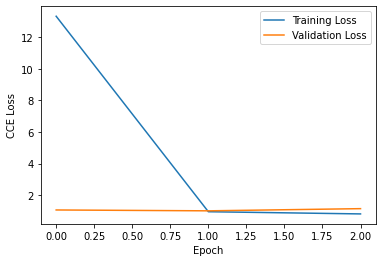

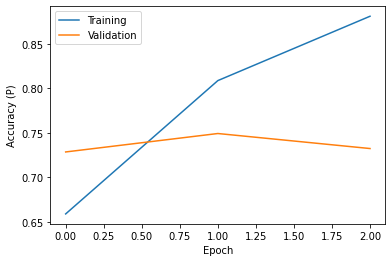

41/41 [==============================] - 1s 36ms/step - loss: 1.1370 - accuracy: 0.7324
{'loss': 1.1370130777359009, 'accuracy': 0.7323619723320007}


INFO:tensorflow:Assets written to: ram://9a30b3bb-c709-42a3-8acc-411c3b300d55/assets


INFO:tensorflow:Assets written to: ram://9a30b3bb-c709-42a3-8acc-411c3b300d55/assets


Epoch 1/3
163/163 [==============================] - 33s 173ms/step - loss: 13.3479 - accuracy: 0.6741 - val_loss: 1.0414 - val_accuracy: 0.7416
Epoch 2/3
163/163 [==============================] - 29s 176ms/step - loss: 0.9405 - accuracy: 0.8071 - val_loss: 1.0110 - val_accuracy: 0.7538
Epoch 3/3
163/163 [==============================] - 30s 181ms/step - loss: 0.7976 - accuracy: 0.8806 - val_loss: 1.0553 - val_accuracy: 0.7408


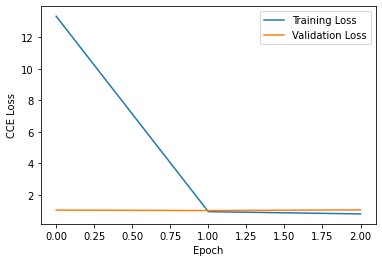

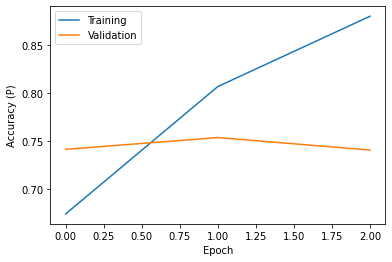

41/41 [==============================] - 1s 25ms/step - loss: 1.0553 - accuracy: 0.7408
{'loss': 1.055261492729187, 'accuracy': 0.7407975196838379}


INFO:tensorflow:Assets written to: ram://b8d00304-a508-4715-b29f-6928fb0e9b2c/assets


INFO:tensorflow:Assets written to: ram://b8d00304-a508-4715-b29f-6928fb0e9b2c/assets


Epoch 1/3
163/163 [==============================] - 33s 180ms/step - loss: 13.3082 - accuracy: 0.6758 - val_loss: 1.0586 - val_accuracy: 0.7193
Epoch 2/3
163/163 [==============================] - 28s 171ms/step - loss: 0.9142 - accuracy: 0.8273 - val_loss: 1.0710 - val_accuracy: 0.7186
Epoch 3/3
163/163 [==============================] - 28s 169ms/step - loss: 0.7815 - accuracy: 0.8930 - val_loss: 1.1583 - val_accuracy: 0.6910


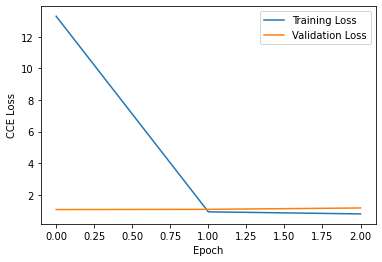

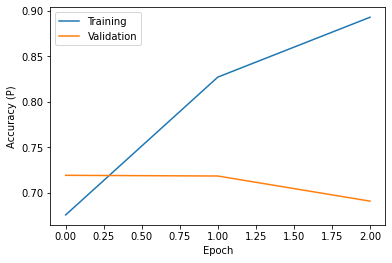

41/41 [==============================] - 1s 24ms/step - loss: 1.1583 - accuracy: 0.6910
{'loss': 1.1583354473114014, 'accuracy': 0.6909509301185608}


INFO:tensorflow:Assets written to: ram://2c3c3a36-e905-4705-945b-578c668ec53c/assets


INFO:tensorflow:Assets written to: ram://2c3c3a36-e905-4705-945b-578c668ec53c/assets


Epoch 1/3
163/163 [==============================] - 33s 175ms/step - loss: 13.3146 - accuracy: 0.6741 - val_loss: 1.0238 - val_accuracy: 0.7592
Epoch 2/3
163/163 [==============================] - 28s 171ms/step - loss: 0.9100 - accuracy: 0.8179 - val_loss: 1.0156 - val_accuracy: 0.7561
Epoch 3/3
163/163 [==============================] - 29s 175ms/step - loss: 0.7694 - accuracy: 0.8917 - val_loss: 1.0964 - val_accuracy: 0.7285


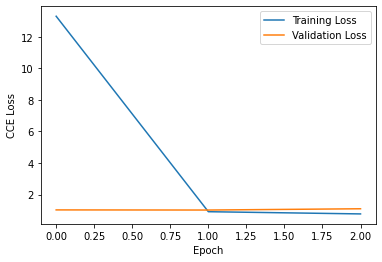

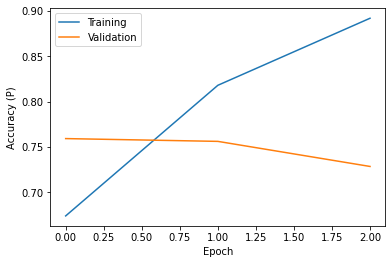

41/41 [==============================] - 1s 24ms/step - loss: 1.0964 - accuracy: 0.7285
{'loss': 1.096396565437317, 'accuracy': 0.7285276055335999}


INFO:tensorflow:Assets written to: ram://5eca0bbb-2f6b-41b0-9506-92a475b3d355/assets


INFO:tensorflow:Assets written to: ram://5eca0bbb-2f6b-41b0-9506-92a475b3d355/assets


Epoch 1/3
163/163 [==============================] - 34s 180ms/step - loss: 13.3314 - accuracy: 0.6794 - val_loss: 1.0315 - val_accuracy: 0.7469
Epoch 2/3
163/163 [==============================] - 27s 168ms/step - loss: 0.9155 - accuracy: 0.8227 - val_loss: 1.0050 - val_accuracy: 0.7653
Epoch 3/3
163/163 [==============================] - 28s 174ms/step - loss: 0.7859 - accuracy: 0.8855 - val_loss: 1.0331 - val_accuracy: 0.7500


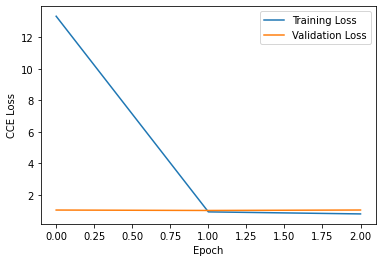

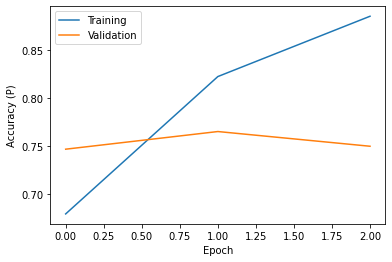

41/41 [==============================] - 1s 25ms/step - loss: 1.0331 - accuracy: 0.7500
{'loss': 1.0330651998519897, 'accuracy': 0.75}


INFO:tensorflow:Assets written to: ram://f5bfbc18-85c4-4277-8ae5-3d11a649f598/assets


INFO:tensorflow:Assets written to: ram://f5bfbc18-85c4-4277-8ae5-3d11a649f598/assets


In [ ]:
ids = np.asarray(X_train)
labels = np.array(Y)
'''
    K FOLD VALIDATION LOOP

   X   create input_id training and validation sets in 
   Y   create label training and validation sets in

   model = none clears memory
   Create model

   Call train model function for learning

   benchmarks saves in evaluate and printed
   predictor made from model and compared to label set


   save model and weights in log_directory
'''
for train_index, val_index in kf.split(ids,labels):
      X_train, X_val = ids[train_index], ids[val_index]
      Y_train, Y_val = labels[train_index], labels[val_index]
          
      model = None
      model = L_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)
      history = train_model(model, X_train, X_val, Y_train, Y_val)
      benchmarks = model.evaluate(X_val,y=Y_val, return_dict=True, batch_size=BATCH_SIZE)
      print(benchmarks)
      with open(model_save_path, 'wb') as f:
          pickle.dump((model, MAX_LEN), f)

In [ ]:
from sklearn.metrics import confusion_matrix,f1_score,classification_report


In [ ]:
preds = model.predict(X_valid_padded,batch_size=16)
pred_labels = preds.argmax(axis=1)
f1 = f1_score(y_valid,pred_labels)
f1

0.6677685950413222

In [ ]:
label_class_dict={0:'notsarc',1:'sarc'}
target_names=label_class_dict.values()

In [ ]:
print('F1 score',f1)
print('Classification Report')
print(classification_report(y_valid,pred_labels,target_names=target_names))

F1 score 0.6677685950413222
Classification Report
              precision    recall  f1-score   support

     notsarc       0.68      0.75      0.71       333
        sarc       0.71      0.63      0.67       319

    accuracy                           0.69       652
   macro avg       0.69      0.69      0.69       652
weighted avg       0.69      0.69      0.69       652

